In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *
from fastai.vision import models

In [4]:
from utils import *

In [5]:
DATA = Path('data')
AUDIOSET = DATA/'audioset_mono'
TRAIN_CSV = AUDIOSET/'train_v2.csv'
VALID_CSV = AUDIOSET/'valid_v2.csv'
LABEL_CSV = AUDIOSET/'class_labels_indices.csv'

def convert_labels(df, label_df):
    df['positive_labels'] = df['positive_labels'].apply(
        lambda s: label_df.loc[s.split(','), 'display_name'].tolist())
    return df

label_df = pd.read_csv(LABEL_CSV, index_col='mid', usecols=['mid', 'display_name'])
train_df, valid_df = [convert_labels(pd.read_csv(f), label_df)
                      for f in [TRAIN_CSV, VALID_CSV]]
len(train_df), len(valid_df)

(18725, 17492)

In [6]:
n_fft = 512
n_hop = 256
n_mels = 128
sample_rate = 22050
top_db = 50.0
ref = 1.0

bs = 8

trn_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, 
    sample_rate=sample_rate, rand_hop_pct=0.15)

val_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, 
    sample_rate=sample_rate)

tfms = get_transforms(min_len=n_fft)

In [7]:
train_list = AudioItemList.from_df(train_df, 
                                   path=AUDIOSET, 
                                   folder='train', 
                                   suffix='.wav')
valid_list = AudioItemList.from_df(valid_df, 
                                   path=AUDIOSET,
                                   folder='valid', 
                                   suffix='.wav')

In [8]:
data = (ItemLists(path=AUDIOSET,
                  train=train_list,
                  valid=valid_list)
            .label_from_df()
            .transform(tfms)
            .databunch(bs=bs, 
                       equal_lengths=True, 
                       collate_fn=pad_collate1d))

data.train_dl.add_tfm(trn_batch_tfms[0])
data.valid_dl.add_tfm(val_batch_tfms[0])

len(data.train_ds), len(data.valid_ds)

(18725, 17492)

In [9]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([8, 1, 128, 904]), torch.Size([8, 527]))

In [10]:
fbeta5 = partial(fbeta, thresh=0.5)
precision5 = partial(precision, thresh=0.5)
recall5 = partial(recall, thresh=0.5)

metrics = [precision, recall, fbeta, precision5, recall5, fbeta5]

### ResNet34

In [28]:
model_name = 'audioset_resnet34_v1'

learn = create_cnn(data, models.resnet34, metrics=metrics)

learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.023945,0.024143,0.356058,0.160234,0.176637,0.185642,0.066679,0.075757
2,0.022613,0.022500,0.381277,0.172306,0.189647,0.238442,0.089159,0.100791
3,0.022222,0.021509,0.405943,0.184764,0.202533,0.258076,0.097470,0.110086
4,0.022429,0.038958,0.401550,0.176492,0.193227,0.237260,0.091329,0.101334
5,0.022151,0.026306,0.398604,0.189142,0.205774,0.260282,0.097492,0.109520
6,0.020856,0.021307,0.409028,0.185915,0.204049,0.231744,0.087350,0.098551
7,0.020339,0.020943,0.409018,0.189277,0.207037,0.243398,0.092537,0.104546
8,0.021030,0.022004,0.402787,0.186193,0.203513,0.248562,0.095391,0.107336


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


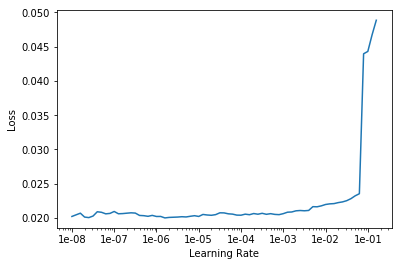

In [29]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [31]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(2, max_lr=1e-4)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.021058,0.022006,0.378280,0.171383,0.187977,0.243428,0.094082,0.105820
2,0.020021,0.021178,0.405838,0.194153,0.210337,0.255877,0.100591,0.112608


### ResNet50

In [11]:
# model_name = 'audioset_resnet50_v1'

# learn = create_cnn(data, models.resnet50, metrics=metrics)

# learn.fit_one_cycle(8)
# learn.save(model_name + '-stage-1')